In [1]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque

pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import torch
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
print(f"CUDA 版本: {torch.version.cuda}")
print(f"GPU 數量: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU 名稱: {torch.cuda.get_device_name(0)}")


PyTorch 版本: 2.7.1+cu118
CUDA 可用: True
CUDA 版本: 11.8
GPU 數量: 1
GPU 名稱: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game


In [4]:
class SpaceShipEnvVector:
    def __init__(self):
        pygame.init()
        pygame.font.init()
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS
        self.game = Game()
        
        # 狀態空間設計 - 總共50維
        self.state_dim = 50
        self.action_space = [0, 1, 2, 3]  # 無動作、左、右、射擊
    
    def get_vector_state(self):
        """提取向量化狀態"""
        state = np.zeros(self.state_dim)
        idx = 0
        
        # 玩家基本信息 (7維)
        player = self.game.player.sprite
        state[idx:idx+7] = [
            player.rect.centerx / WIDTH,        # 玩家x位置 (標準化)
            player.rect.centery / HEIGHT,       # 玩家y位置 (標準化)
            player.speedx / 10.0,               # 玩家x速度
            player.health / 100.0,              # 生命值 (標準化)
            player.lives / 3.0,                 # 生命數 (標準化)
            min(player.gun, 3) / 3.0,           # 槍械等級 (標準化)
            1.0 if not player.hidden else 0.0   # 是否隱藏
        ]
        idx += 7
        
        # 最近5個石頭信息 (25維: 每個石頭5維)
        rocks = sorted(list(self.game.rocks), 
                      key=lambda r: ((r.rect.centerx - player.rect.centerx)**2 + 
                                   (r.rect.centery - player.rect.centery)**2))[:5]
        for i in range(5):
            if i < len(rocks):
                rock = rocks[i]
                state[idx:idx+5] = [
                    rock.rect.centerx / WIDTH,   # 石頭x位置
                    rock.rect.centery / HEIGHT,  # 石頭y位置
                    rock.speedx / 10.0,          # 石頭x速度
                    rock.speedy / 10.0,          # 石頭y速度
                    rock.radius / 50.0           # 石頭半徑
                ]
            idx += 5
        
        # 最近3個子彈信息 (12維: 每個子彈4維)
        bullets = list(player.bullet_group)[:3]
        for i in range(3):
            if i < len(bullets):
                bullet = bullets[i]
                state[idx:idx+4] = [
                    bullet.rect.centerx / WIDTH,  # 子彈x位置
                    bullet.rect.centery / HEIGHT, # 子彈y位置
                    bullet.speedy / 10.0,         # 子彈y速度
                    1.0                           # 子彈活躍狀態
                ]
            idx += 4
        
        # 最近2個道具信息 (6維: 每個道具3維)
        powers = list(self.game.powers)[:2]
        for i in range(2):
            if i < len(powers):
                power = powers[i]
                power_type = 1.0 if power.type == 'shield' else 0.0
                state[idx:idx+3] = [
                    power.rect.centerx / WIDTH,   # 道具x位置
                    power.rect.centery / HEIGHT,  # 道具y位置
                    power_type                    # 道具類型
                ]
            idx += 3
        
        return state
    
    def calculate_reward(self, prev_score, prev_health, prev_lives):
        """計算獎勵函數"""
        reward = 0
        
        # 分數獎勵 - 主要目標
        score_diff = self.game.score - prev_score
        if score_diff > 0:
            reward += score_diff * 1.0
        
        # 生存獎勵
        if self.game.running:
            reward += 3.0
        else:
            reward -= 500  # 死亡懲罰
        
        # 傷害懲罰
        health_diff = self.game.player.sprite.health - prev_health
        if health_diff < 0:
            reward -= abs(health_diff) * 2.0
        elif health_diff > 0:
            reward += health_diff * 0.5   
              
        if self.game.is_power:
            reward += 50.0
            
        return reward
    
    def step(self, action):
        # 記錄前一步狀態
        prev_score = self.game.score
        prev_health = self.game.player.sprite.health
        prev_lives = self.game.player.sprite.lives
        
        # 執行動作
        self.game.update(action)
        
        # 繪製畫面（訓練時可以關閉以加速）
        if self.screen is None:
            self.game.draw()
        else:
            self.game.draw(self.screen)
            self.clock.tick(self.fps)
        
        # 獲取新狀態
        state = self.get_vector_state()
        
        # 計算獎勵
        reward = self.calculate_reward(prev_score, prev_health, prev_lives)
        
        # 判斷遊戲結束
        done = not self.game.running or self.game.score >= 10000
        
        # 附加信息
        info = {'score': self.game.score}
        
        return state, reward, done, info
    
    def reset(self):
        self.game = Game()
        return self.get_vector_state()
    
    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")
    
    def close(self):
        pygame.quit()


In [5]:
# Hyperparameters
num_episodes = 14000
batch_size = 64
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.999
memory_capacity = 100000  # 100000
target_update_freq = 1000   # 1000

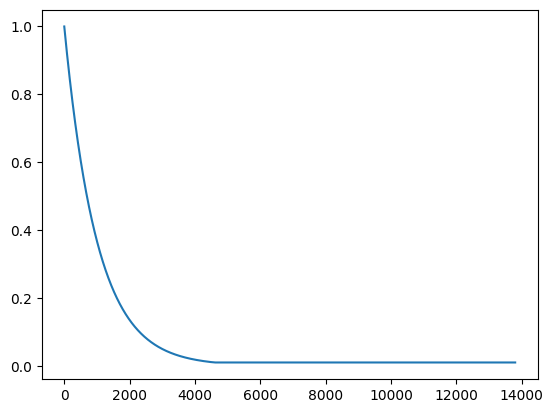

In [6]:
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [8]:
class VectorDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(VectorDQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),      # 添加層歸一化提升訓練穩定性
            nn.Dropout(0.1),        # 防止過擬合
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)


In [9]:
# Replay buffer
# 用於儲存代理人經驗（狀態、動作、獎勵等）的緩衝區，支援隨機抽樣以打破時間相關性，有助於穩定訓練。

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # Use deque with a fixed capacity to automatically discard the oldest experience when full.
        # 使用 deque 並設定最大長度，當容量滿時會自動移除最舊的資料。

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        # Store a single transition (experience) in the buffer.
        # 儲存一筆經驗（狀態轉移）進緩衝區。

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Randomly sample a batch of transitions to break correlation between consecutive samples.
        # 隨機抽取一批經驗，打破樣本間的時間關聯性，提高訓練穩定性。

        # Unpack each element into separate tensors for network input
        # 將 batch 拆解成分別的 tensor 以供神經網路訓練
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert the sampled data into tensors and move them to the specified device (CPU or GPU)
        # 將抽樣資料轉成 tensor 並移至指定設備（CPU/GPU）
        states = torch.tensor(np.stack(states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)
        # Return the current size of the buffer.
        # 回傳緩衝區目前儲存的資料數量。


In [10]:
# 初始化向量環境
env = SpaceShipEnvVector()

# 向量DQN參數設定
state_dim = 50          # 向量狀態維度
num_actions = 4         # 動作數量

# 初始化向量DQN模型
policy_net = VectorDQN(state_dim, num_actions).to(device)
target_net = VectorDQN(state_dim, num_actions).to(device)

# 將target網路參數設為與policy網路相同
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target網路設為評估模式

# 優化器
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# 使用ReplayBuffer而非ReplayMemory
memory = ReplayBuffer(memory_capacity)

# 載入模型（若有）
if os.path.exists('checkpoint_vector_best3642.pth'):
    checkpoint = torch.load('checkpoint_vector_best3642.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode = checkpoint['episode'] + 1
    total_steps = checkpoint['total_steps']
    best_score = checkpoint['best_score']
    epsilon = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']
    score_history = checkpoint['score_history']
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    total_steps = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []



Loaded checkpoint from episode 13705, best score: 9138.00, epsilon=0.011


In [ ]:
# 訓練迴圈 - 向量版本
for episode in range(start_episode, num_episodes):
    state = env.reset()  # 直接獲得50維向量，無需預處理
    total_reward, done = 0, False

    while not done:
        # ε-greedy 策略：隨機選擇動作或從模型中選擇
        if random.random() < epsilon:
            action = random.choice(env.action_space)
        else:
            with torch.no_grad():
                # 直接使用向量狀態，無需stack_frames
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(dim=1).item()

        # 執行動作
        next_state, reward, done_, info = env.step(action)
        done = done_
        total_reward += reward
        score = info['score']  # 從info字典中獲取分數

        # 存儲經驗 - 直接使用向量狀態
        memory.push(state, action, reward, next_state, done)
        state = next_state

        # 訓練模型
        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)
            
            # 移到設備
            states = states.to(device)
            actions = actions.to(device)
            rewards = rewards.to(device)
            next_states = next_states.to(device)
            dones = dones.to(device)

            with torch.no_grad():
                target_q = rewards + gamma * target_net(next_states).max(1)[0] * (1 - dones)

            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = F.mse_loss(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新 target 網路
        total_steps += 1
        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # 更新 epsilon 並紀錄統計資料
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    reward_history.append(total_reward)
    score_history.append(score)

    print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Epsilon: {epsilon:5.3f}")

    # 儲存模型（若比目前最佳分數更好，或每 50 回合）
    if (episode + 1) % 50 == 0:
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, 'checkpoint_vector.pth')

        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")
    if score > 4000:
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, f'checkpoint_vector_best{score}.pth')

        print(f"Best result saved at episode {episode + 1}, best score: {best_score:.2f}")

env.close()

Episode 13706, Reward: 11589.00, Score: 1294, Epsilon: 0.011
Episode 13707, Reward: 3021.00, Score:  368, Epsilon: 0.011
Episode 13708, Reward: 3136.00, Score:  468, Epsilon: 0.011
Episode 13709, Reward: 4031.00, Score:  594, Epsilon: 0.011
Episode 13710, Reward: 13263.50, Score: 1986, Epsilon: 0.011
Episode 13711, Reward: 3083.00, Score:  460, Epsilon: 0.011
Episode 13712, Reward: 10218.00, Score: 1172, Epsilon: 0.011
Episode 13713, Reward: 10855.00, Score: 1700, Epsilon: 0.011
Episode 13714, Reward: 3765.00, Score:  552, Epsilon: 0.011
Episode 13715, Reward: 4143.00, Score:  444, Epsilon: 0.011
Episode 13716, Reward: 4684.00, Score:  786, Epsilon: 0.011
Episode 13717, Reward: 2210.00, Score:  416, Epsilon: 0.011
Episode 13718, Reward: 2639.00, Score:  326, Epsilon: 0.011
Episode 13719, Reward: 8057.00, Score: 1002, Epsilon: 0.011
Episode 13720, Reward: 2532.00, Score:  414, Epsilon: 0.011
Episode 13721, Reward: 8261.00, Score: 1276, Epsilon: 0.011
Episode 13722, Reward: 16734.00, Sco

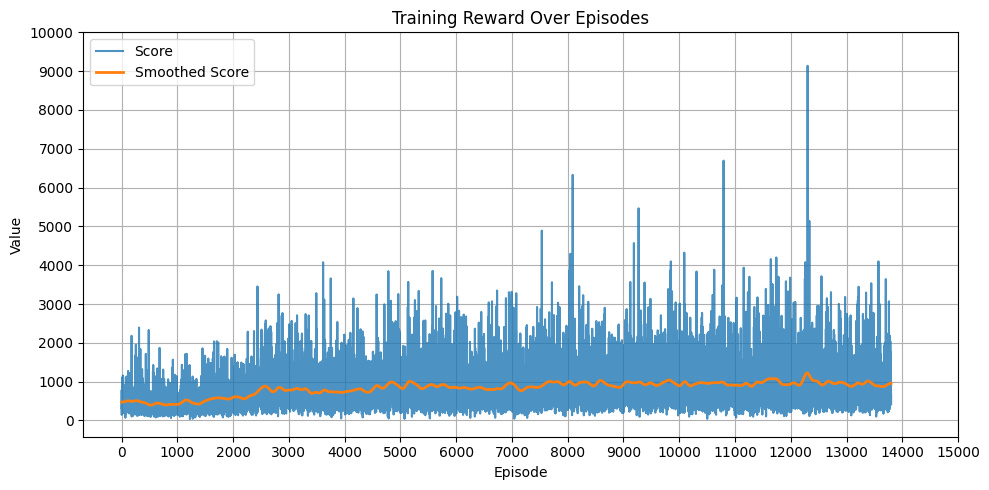

In [ ]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
plt.figure(figsize=(10, 5))
# plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
# plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.xticks(range(0, 15001, 1000))
plt.ylabel("Value")
plt.yticks(range(0, 10001, 1000))
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
plt.savefig("dqn_training_curve1.png")

